In [0]:
import tarfile
import os, shutil
import json
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
! pwd

/content


In [0]:
# Read the compressed directory
tar = tarfile.open("/content/gdrive/My Drive/COCO/fish_dataset/fish_dataset.tar.gz")
tar.extractall()
tar.close()

In [0]:
with open("/content/output/README.txt") as f:
  dataset_info = f.read()

print(dataset_info)

This folder contains 13,000 synthetic images for fish instance segmentation. The file is structured as follows:

images: A folder with 13,000 artificially-created images in .jpg format. Each image is 512 x 512 pixels and contains between 1 and 12 fish instances per image on random backgrounds.

masks: Segmentation mask images (13,000 total) for the images. Each image has its own segmentation mask. Image and corresponding mask have identical filenames.

coco_instances.json: COCO-style annotations file with labels, bounding boxes and segmentations. This file is necessary for training and validation. Accessible by COCO API or similar.

mask_definitions.json: Original mask images included for reference. Used to create the information in coco_instances.json 

Dataset_info.json: General dataset info similar to COCO format. Data in this file is fictional, included only for completeness.

It is recommended to maintain this directory structure to ensure matching alignment of images and annotati

Grab a random image and mask as quick verification that everything has been set up correctly.

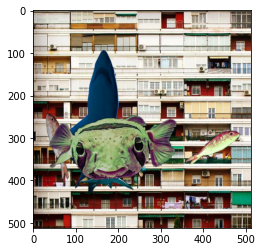

In [0]:
imgs = os.listdir("/content/output/images")
img = np.random.choice(imgs)
plt.imshow(Image.open("/content/output/images/"+img))

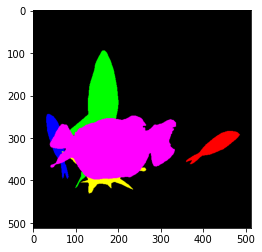

In [0]:
# Note: mask files have same filename as corresponding image but are .png
plt.imshow(Image.open(("/content/output/masks/"+img).replace("jpg", "png")))

After verifying images have been properly decompressed and loaded, the remainder of this script can be used to create subsets of the larger fish dataset. 

In order for the training and validation sets to be set up correctly, the directory structure must be set up correctly and each training and validation directory should have a COCO-style .json file for all the instances used for training and validation.

In [0]:
coco_p = Path('./output/coco_instances.json').absolute()
with open(coco_p) as f:
    coco_json = json.load(f)

Create "lookup" lists to for creation of coco_json dicts for image subsets. This makes it much faster to process the dict for the new .json file.

In [0]:
# Look up image id's by image filename
img_ids = [coco_json.get('images')[i].get('id') for i in range(len(coco_json['images']))]
img_files = [coco_json.get('images')[i].get('file_name') for i in range(len(coco_json['images']))]
img_lookup = dict(zip(img_files, img_ids))

In [0]:
# Look up annotations by image id's
from itertools import groupby
img_ann = [coco_json.get('annotations')[i].get('image_id') for i in range(len(coco_json['annotations']))]
_ = list(enumerate(sorted(img_ann)))
ann_lookup = dict()
for k, v in groupby(_, lambda x:x[1]):
    ann_lookup[k] = [v[0] for v in list(v)]

The following function is used to create a new coco_json that corresponds to the smaller sample. It utilizes the "lookup" lists created above for quick execution.

In [0]:
from collections import defaultdict
# Create new coco_json for the smaller set of images
def coco_sub_json(img_files, coco_json=coco_json):
    '''
    Takes a set of images in a list and creates a smaller corresponding coco_json dictionary for the subset from the 
    main coco_instance json file.
    -----------------------------
    img_files = list of images for which to create the new coco_json dict
    coco_json = original (large) dict from main coco_instances.json
    '''
    new_dict = defaultdict().fromkeys(list(coco_json.keys()))
    new_dict['info'] = coco_json.get('info').copy()
    new_dict['licenses'] = coco_json.get('licenses').copy()
    new_dict['categories'] = coco_json.get('categories').copy()
    new_dict['images'] = []
    ann = coco_json.get('annotations')
    new_dict['annotations'] = []
    
    for file in img_files:
        idx = img_lookup.get(file)
        new_dict['images'].append(coco_json.get('images')[idx].copy())
        for ann_id in ann_lookup[idx]:
            new_dict['annotations'].append(ann[ann_id])
    
    return new_dict

Create subsets of randomly-selected images for training and validation. Any number of images can be selected up to the maximum available in the full dataset (in this case 13000 images). The default example below creates 1000 train images and 200 validation images.

In [0]:
img_path = Path("./output/images/").absolute()
images = os.listdir(img_path)
fish_subset = [img_name for img_name in np.random.choice(images, size=13000, replace=False)]
train = fish_subset[:7000]
val = fish_subset[7000:10000]
test = fish_subset[10000:13000]

Finally, the training and validation directories are created, the images for each set are added to the directories and an appropriate `coco_instances.json` file is created and added to each directory. This directory structure can be utilized directly in the model.

Multiple subsets can be created and saved out by creating new lists for `sub_train` and/or `sub_val` above and modifying the path below (e.g. change `subset/` below to `subset1/`, `subset2/`, etc.) with new folders.

In [0]:
src = img_path
dest_tr, dest_v, dest_test = ("./subset0/{}/".format(x) for x in ["train", "val","test"])

for item in [(dest_tr,train),(dest_v,val),(dest_test, test)]:
    os.makedirs(item[0] + "images/")
    for img in item[1]:
        shutil.copy(str(src) + "/" + img, item[0] + "images/" + img)
    with open(item[0] + 'coco_instances.json', 'w') as f:
        json.dump(coco_sub_json(item[1]), f)

In [0]:

src = img_path
dest_tr, dest_v = ("./subset/{}/".format(x) for x in ["train", "val"])

for item in [(dest_tr,sub_train),(dest_v,sub_val)]:
    os.makedirs(item[0] + "images/")
    for img in item[1]:
        shutil.copy(str(src) + "/" + img, item[0] + "images/" + img)
    with open(item[0] + 'coco_instances.json', 'w') as f:
        json.dump(coco_sub_json(item[1]), f)


In [0]:
! pwd

/content
